# Exploratory Data Analysis (EDA)
1. Categorical Variables
2. Numerical Variables
3. Features vs Targets
4. Dataset

In [1]:
# LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt

### Import the clean data

In [2]:
df_raw = pd.read_csv('Best_Book_21st_clean_dataset.csv')
df_raw.head()

,title,series,author,genre,date_published,publisher,lang,rating_count,rate,award,publisher_clean
0,Fantastic Beasts and Where to Find Them,True,Newt Scamander,Fantasy,2001.0,Arthur A. Levine Books,English,372109,3.96,0,arthuralevinebooks
1,Houdini Heart,False,Ki Longfellow,Horror,2011.0,Eio Books,English,10409,3.75,0,eiobooks
2,"An Echo in the Bone (Outlander, #7)",True,Diana Gabaldon,Historical,2010.0,Orion,English,133940,4.40,2,orion
3,Three Junes,False,Julia Glass,Fiction,2003.0,Anchor,English,45789,3.56,1,anchor
4,"The Dark Tower (The Dark Tower, #7)",True,Stephen King,Fantasy,2006.0,Pocket Books,English,162749,4.23,1,pocketbooks


### Reviewing data types

In [3]:
# First, let's see what data types we have available
df = df_raw.copy()
df.dtypes

title               object
series                bool
author              object
genre               object
date_published     float64
publisher           object
lang                object
rating_count         int64
rate               float64
award                int64
publisher_clean     object
dtype: object

In [4]:
# We can separate them in Categorical and Numerical (Boolean will be considered numerical since it can be easily transformed to 0s and 1s)
# Transforming boolean to numerical
for boolean_col in df.select_dtypes(include='bool').columns:
    df[boolean_col] = df[boolean_col].astype(int)
df.dtypes

title               object
series               int64
author              object
genre               object
date_published     float64
publisher           object
lang                object
rating_count         int64
rate               float64
award                int64
publisher_clean     object
dtype: object

## 1. Categorical Variables

In [5]:
# Before visually analyzing the variables, let's see how many unique values each column has
# Since in a Machine Learning model we have a column -1 per unique value of a category variable the approach will be:
#  - 20 unique values should represent at least 80% of the total data (similar to a Pareto approach)
#  - If true, reduce these unique values by retrieving the most common values for each category, and group the rest in "Other"
#  - If false, the variable should not be included in the model, since it will create a very complex model without contributing much to it
df.select_dtypes(include='object').nunique()

title              9092
author             5213
genre               113
publisher          2491
lang                 42
publisher_clean    2148
dtype: int64

In [6]:
# We will define a function to retrieve the top "num" values of "column", excluding all "unknown" values
def top_values_of_column(column, num):
    top_num_column = df[~df[column].isin(['Unknown','unknown'])].groupby(by=column)[column].count().sort_values(ascending = False).head(num)
    return top_num_column

**Variables to be removed: title, publisher, author, publisher_clean**

In [7]:
# title is basically an "id" of the book, which means it won't bring any value to the model
# publisher is not the standardize name of the publisher, so we will drop this variable and evaluate publisher_clean instead
df.drop(['title','publisher'], axis=1, inplace=True)

In [8]:
# Reviewing the author variable, we notice that the top 20 authors represent only 5% of all the data, which means it's not meaningful to add them to the model
top_20_authors = top_values_of_column('author',20)
print(f"Top 20 authors cover {top_20_authors.sum()} records, which only represents {round((top_20_authors.sum()/len(df))*100)}% of the total records")
print(top_20_authors)

# author should be dropped
df.drop('author', axis=1, inplace=True)

Top 20 authors cover 470 records, which only represents 5% of the total records
author
Alex Archer           53
James Patterson       37
Lucian Bane           34
Stephen King          30
Lynsay Sands          26
Scott McElhaney       24
Jeremy Robinson       22
Cassandra Clare       21
Jim Butcher           21
Kelley Armstrong      20
Richelle Mead         20
Neil Gaiman           20
Rick Riordan          20
Terry Pratchett       20
Charlaine Harris      19
Byron Goines          18
Victoria Laurie       18
Derek Landy           16
Catherine Anderson    16
Bernard Cornwell      15
Name: author, dtype: int64


In [9]:
# Reviewing the publisher variable, we notice that the top 20 authors represent only 18% of all the data, which means it's not meaningful to add them to the model
top_20_publishers = top_values_of_column('publisher_clean',20)
print(f"Top 20 publishers cover {top_20_publishers.sum()} records, which only represents {round((top_20_publishers.sum()/len(df))*100)}% of the total records")
print(top_20_publishers)

# publisher_clean should be dropped
df.drop('publisher_clean', axis=1, inplace=True)

Top 20 publishers cover 1603 records, which only represents 18% of the total records
publisher_clean
harpercollins                               126
simonschuster                               103
randomhouse                                 101
littlebrowncompany                           99
stmartinspress                               92
vintage                                      88
createspaceindependentpublishingplatform     87
grandcentralpublishing                       83
ballantinebooks                              79
harper                                       79
knopf                                        79
williammorrow                                73
farrarstrausgiroux                           73
wwnortoncompany                              68
torbooks                                     66
littlebrownbooksforyoungreaders              63
scribner                                     63
orbit                                        61
bantam                             

**Variables to be reclassified: genre, language**

In [10]:
# Reviewing the genre variable, 80% of the values are in the top 20 genres. Therefore, we can reclassify it to gather the remaining 20% in "Other" value
top_20_genre = top_values_of_column('genre',20)
print(f"Top 20 genres cover {top_20_genre.sum()} records, which represents {round((top_20_genre.sum()/len(df))*100)}% of the total records")
print(top_20_genre)

# Reclassifying the remaining 20% to other
df.loc[(~df['genre'].isin(top_20_genre.index)), 'genre'] = 'Other'

Top 20 genres cover 7285 records, which represents 80% of the total records
genre
Fiction            1407
Fantasy            1398
Nonfiction          706
Historical          598
Young Adult         590
Mystery             436
Romance             407
Science Fiction     321
History             306
Sequential Art      189
Horror              158
Childrens           123
Thriller            115
Biography           113
Short Stories       102
Poetry               85
Media Tie In         59
Science              58
Religion             57
Womens Fiction       57
Name: genre, dtype: int64


In [11]:
# For the lang variable, we will first update it to "language"
df.rename(columns={'lang': 'language'}, inplace=True)

# Reviewing the language variable, 94% of the values are in the top 20 languages. Therefore, we can reclassify it to gather the remaining 6% in "Other" value
top_20_languages = top_values_of_column('language',20)
print(f"Top 20 languages cover {top_20_languages.sum()} records, which represents {round((top_20_languages.sum()/len(df))*100)}% of the total records")
print(top_20_languages)

# Reclassifying the remaining 6% to other
df.loc[(~df['language'].isin(top_20_languages.index)), 'language'] = 'Other'

Top 20 languages cover 8599 records, which represents 94% of the total records
language
English                  8269
German                     60
French                     46
Spanish                    35
Dutch                      31
Greek, Modern (1453-)      24
Italian                    21
Portuguese                 21
Arabic                     19
Swedish                    15
Polish                     15
Finnish                    13
Danish                      8
Russian                     5
Norwegian                   4
Persian                     3
Urdu                        3
Catalan; Valencian          3
Ukrainian                   2
Chinese                     2
Name: language, dtype: int64


In [12]:
# Now we have only 21 different values for categorical variables
df.select_dtypes(include='object').nunique()

genre       21
language    21
dtype: int64

**Graphs for Categorical Variables**

In [13]:
def graph_categorical_variables(dataframe):
    variables = dataframe.select_dtypes(include=['object']).columns # Select categorical variables
    plot_rows = round(len(variables)/2) + (len(variables)%2 > 0) # Define the number of rows of plots we will need
    fig, axes = plt.subplots(plot_rows, 2, figsize = (16, plot_rows * 6)) # Generate the figure and axes
    fig.set_facecolor(color='whitesmoke') # Set background color
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    for i in range(len(variables)): # Loop through the plots
        counts = dataframe[variables[i]].value_counts() # Counts for each category of the variable
        axes[i].set_title(variables[i]) # Set title
        axes[i].set_facecolor(color='#F5FFFA') # Set plot background color
        axes[i].barh(counts.index, counts.values, color='teal') # Generate bar plot
        axes[i].grid(True, axis='x', color='0.8', dashes=(5,2,10,2)) # Add gridlines

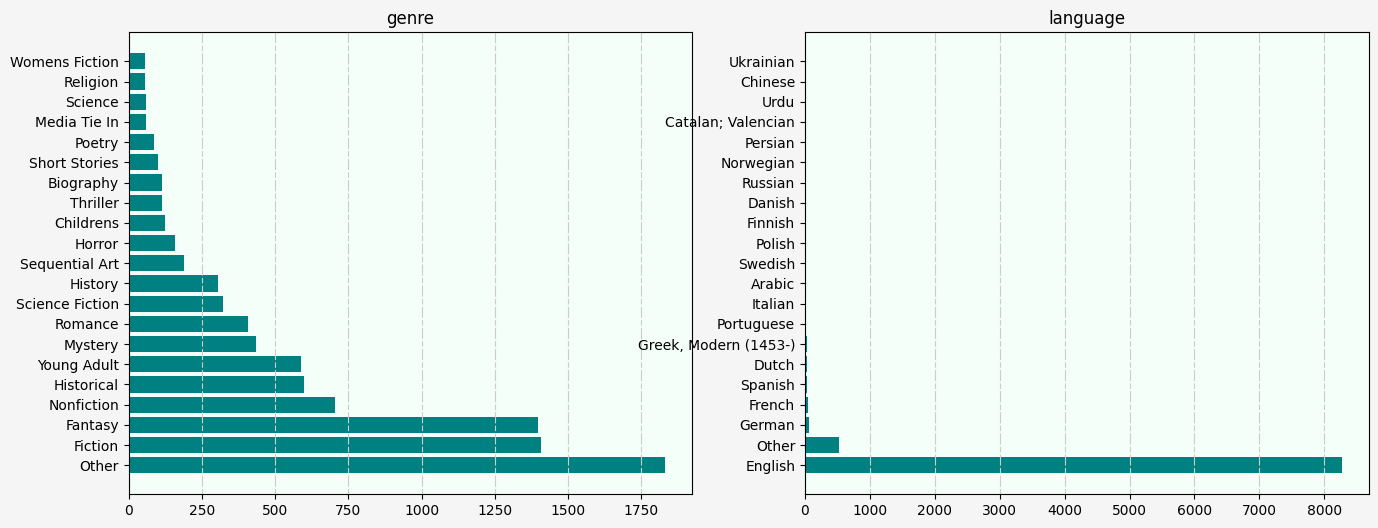

In [14]:
graph_categorical_variables(df)

In [15]:
# Looking at the graphs we can see that English is the main language for most books. Therefore, we can reclassify the language variable to a boolean/numerical variable
# english_lan will be 1 (its main language is English) or 0 (its main language is not English)
df['english_lan'] = df['language'].apply(lambda x: 1 if x=='English' else 0)

# language should be dropped
df.drop('language', axis=1, inplace=True)

## 2. Numerical Variables

In [16]:
# Next, let's review the numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
series,9117.0,0.430953,0.495237,0.00,0.00,0.00,1.00,1.0
date_published,8987.0,2010.187604,4.436230,1972.00,2007.00,2010.00,2013.00,2021.0
rating_count,9117.0,46338.960623,189674.745762,1.00,513.00,5207.00,27870.00,7041451.0
rate,9117.0,3.990308,0.334197,1.89,3.79,3.99,4.19,5.0
award,9117.0,0.901832,1.507082,0.00,0.00,0.00,1.00,12.0
english_lan,9117.0,0.906987,0.290467,0.00,1.00,1.00,1.00,1.0


**Variables to be removed: rating_count**

In [17]:
# Since our goal is to find correlation between a book's variables and its success, we can safely remove the rating_count
df.drop('rating_count', axis=1, inplace=True)

**Variables to be filled: date_published**

In [18]:
# As we can see, there are 130 missing values in the date_published. Since it's not a big amount (around 1.4%), we will replace it with the mean
df['date_published'].fillna(2010, inplace=True)

**Graphs for Numerical Variables**

In [19]:
def graph_numerical_variables(dataframe):
    variables = dataframe.select_dtypes(include=['number']).columns # Select numerical variables
    plot_rows = round(len(variables)/2) + (len(variables)%2 > 0) # Define the number of rows of plots we will need
    fig, axes = plt.subplots(plot_rows, 2, figsize = (16, plot_rows * 6)) # Generate the figure and axes
    fig.set_facecolor(color='whitesmoke') # Set background color
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    for i in range(len(variables)): # Loop through the plots
        axes[i].set_title(variables[i]) # Set title
        axes[i].set_facecolor(color='#F5FFFA') # Set plot background color
        axes[i].hist(df[variables[i]], color='teal') # Generate histogram plot
        axes[i].grid(True, axis='y', color='0.8', dashes=(5,2,10,2)) # Add gridlines

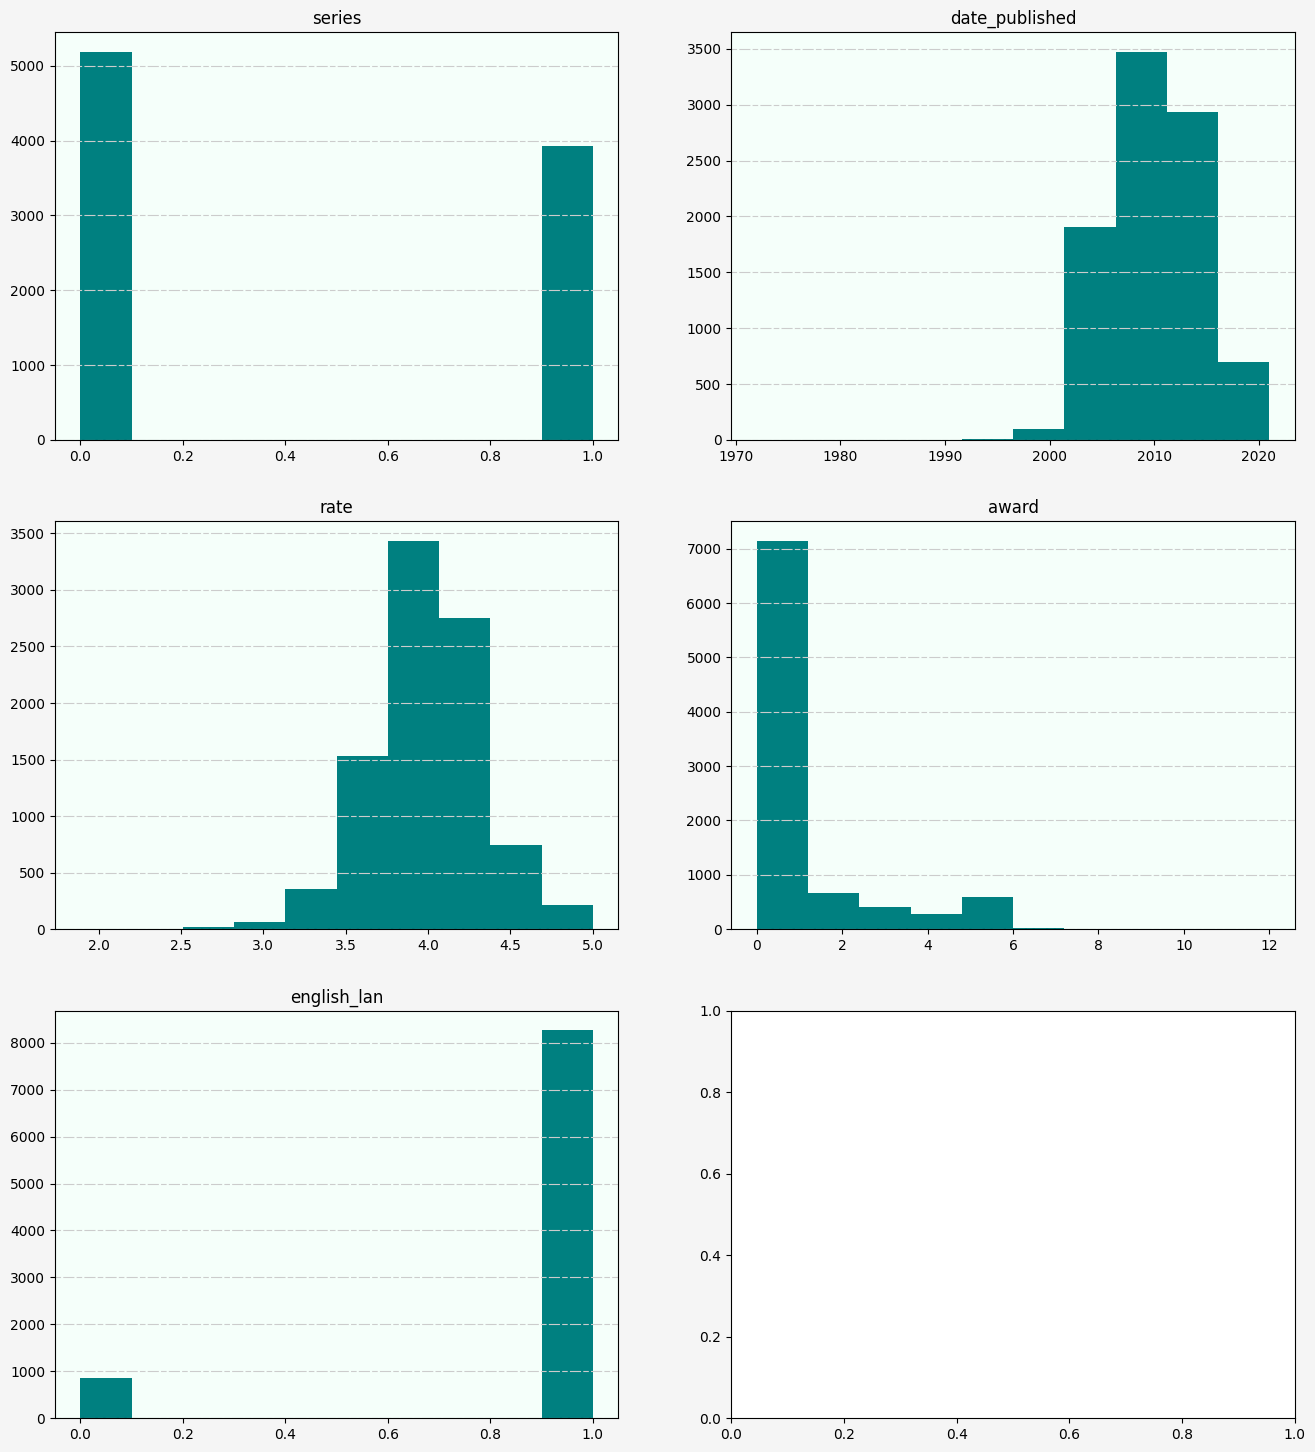

In [20]:
graph_numerical_variables(df)

## 3. Features vs Targets

In [21]:
def graph_features_vs_targets(dataframe, target_list):
    feature_list = dataframe.columns.difference(target_list) # Select features
    total_plots = len(feature_list) * len(target_list) # Define the number of plots we will need
    plot_rows = round(total_plots/2) + (total_plots%2 > 0) # Define the number of rows of plots we will need
    fig, axes = plt.subplots(plot_rows, 2, figsize = (16, plot_rows * 6)) # Generate the figure and axes
    fig.set_facecolor(color='whitesmoke') # Set background color
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    plot_num = 0 # Counter of plots to be used in the loop
    for i in range(len(feature_list)): # Loop through the plots
        for j in range(len(target_list)): # Loop through the plots
            axes[plot_num].set_title(feature_list[i] + ' vs ' + target_list[j]) # Set title
            axes[plot_num].set_facecolor(color='#F5FFFA') # Set plot background color
            axes[plot_num].scatter(df[feature_list[i]],df[target_list[j]], color='teal') # Generate scatter plot
            axes[plot_num].grid(True, axis='y', color='0.8', dashes=(5,2,10,2)) # Add gridlines
            if dataframe[feature_list[i]].dtype == 'O': # If the feature is categorical:
                axes[plot_num].tick_params(axis='x', labelrotation=90) # Then rotate the labels to avoid overlapping
            plot_num = plot_num + 1 # Go to the next plot

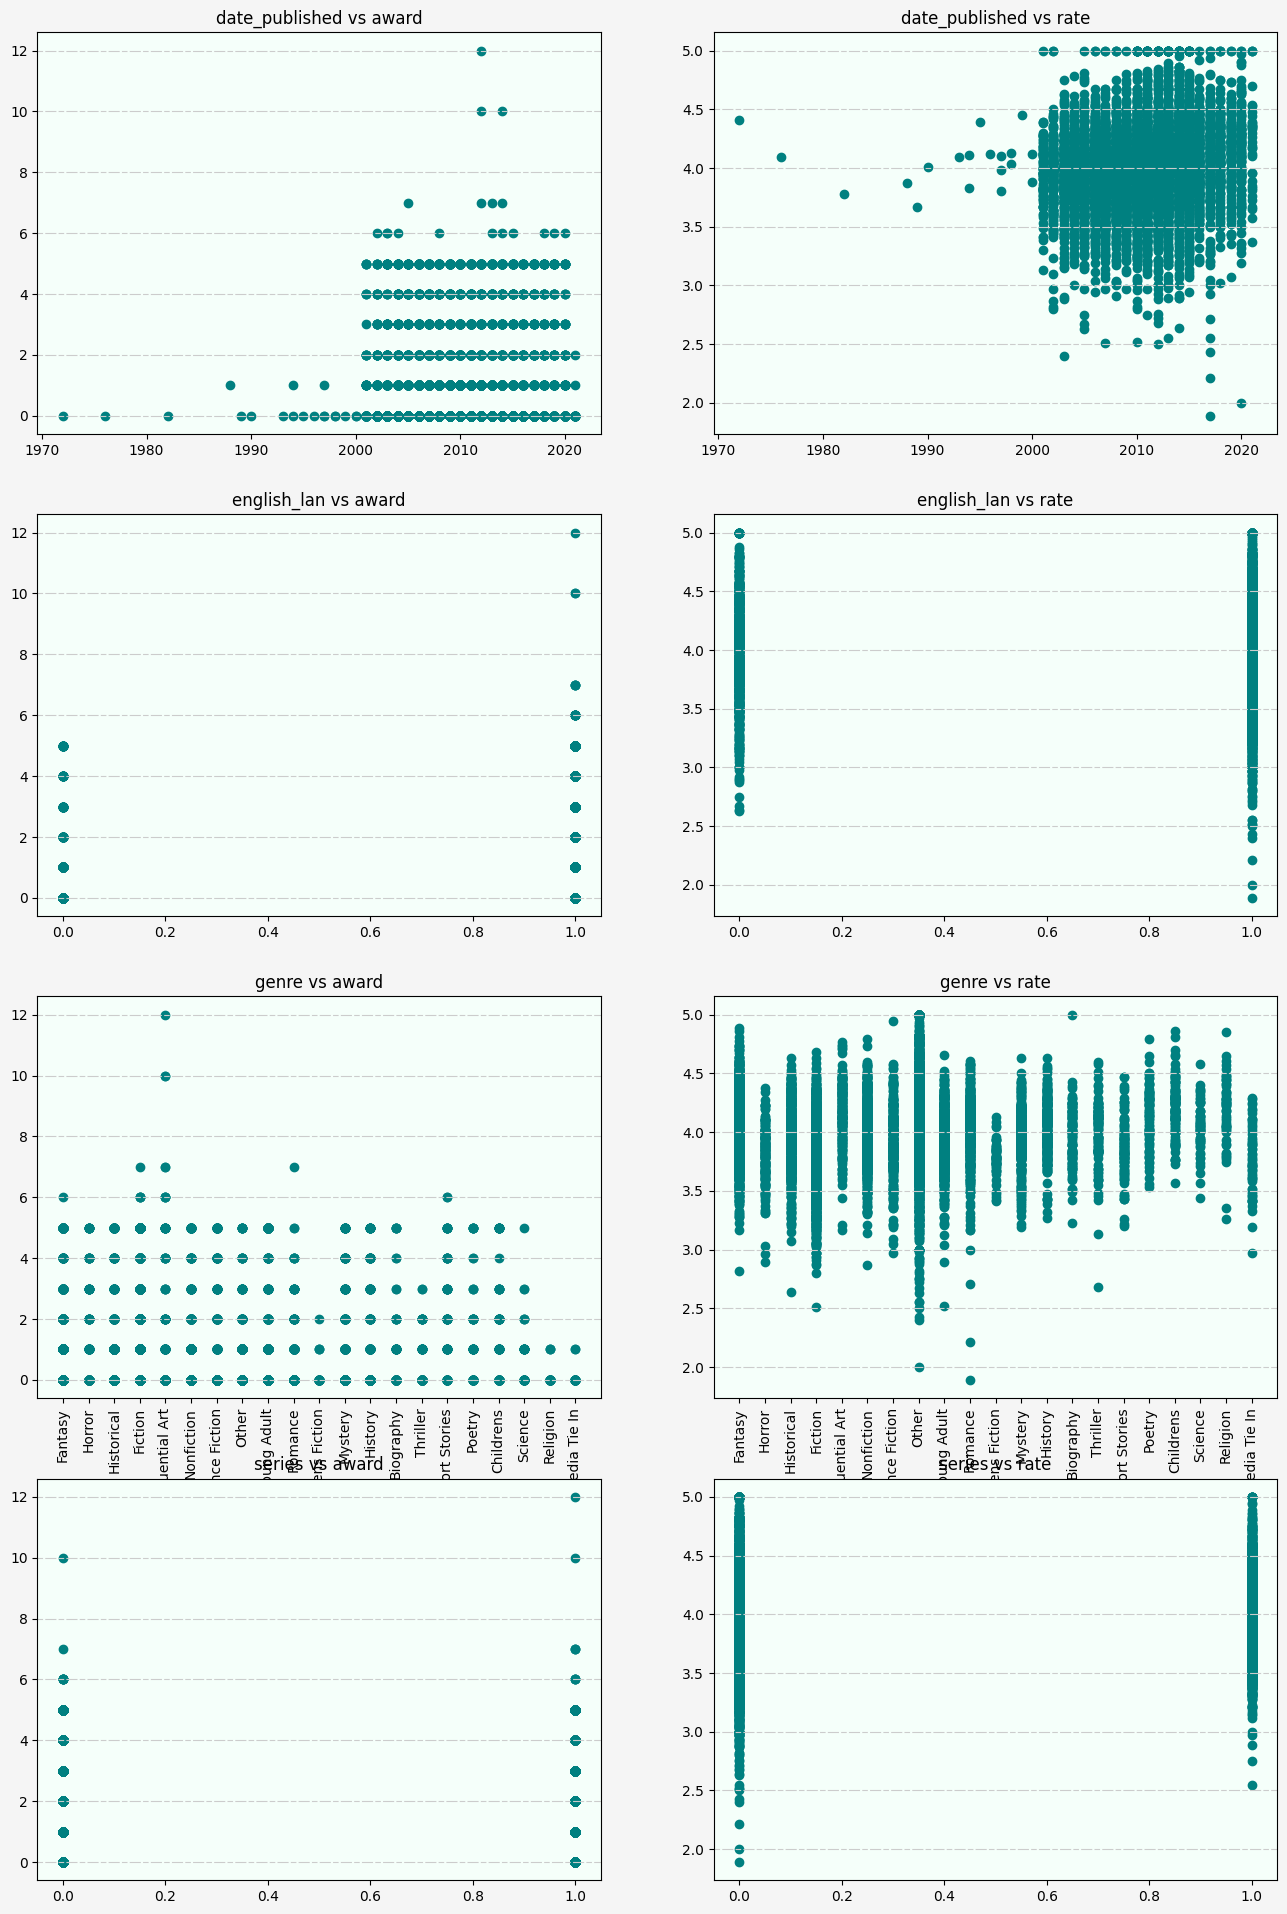

In [22]:
# Let's compare each feature vs each target
graph_features_vs_targets(df,['award','rate'])
# 1. date_published: The awards seem to increase with the date_published. However, this could be due to the increase of books amount we have after the year 2000.
#    We can also see this increase in books in the date_published vs rate. During the modeling, we will need to determine if this feature is significant.
# 2. english_lan: Similarly, books with english as their main language seem to have a higher amount of awards. It's possible that if a book is not written in english,
#    it is not considered for certain awards. Since we want to predict a book's success, this feature may be significant during the modeling. However, it may not be
#    that significant when predicting the rate.
# 3. genre: It seems that the genre does affect the amount of awards and the mean rate with each category. For example, if we compare Sequential Art vs Fiction, we can see
#    we have a higher amount of awards for Sequential Art, even when we have more Fiction books. Also, the mean rate of Sequential Arts seems to be higher than the mean
#    rate for fiction.
# 4. series: Both the amount of awards and the mean rate seems to be higher when the book is part of a series.

# Final dataset saved to CSV

In [23]:
df_final = df.copy()
df_final

,series,genre,date_published,rate,award,english_lan
0,1,Fantasy,2001.0,3.96,0,1
1,0,Horror,2011.0,3.75,0,1
2,1,Historical,2010.0,4.40,2,1
3,0,Fiction,2003.0,3.56,1,1
4,1,Fantasy,2006.0,4.23,1,1
...,...,...,...,...,...,...
9112,1,Fantasy,2012.0,4.01,0,1
9113,1,Childrens,2010.0,4.24,0,1
9114,0,Other,2005.0,3.55,0,1
9115,0,Other,2002.0,3.61,0,1


In [24]:
df_final.to_csv('Best_Book_21st_simplified_dataset.csv', index = False)